#                  V- REP - Poppy balance behavior using IMU and Gyroscope

First you need to instanciate the robot


In [1]:
from poppy.creatures import PoppyHumanoid

poppy = PoppyHumanoid(simulator='vrep')

%pylab inline
import time

Populating the interactive namespace from numpy and matplotlib


This test is bases on the information you can retrieve from an IMU sensor. In fact, you can have the absolute x,y,z position of the head (assuming the IMU is in the head of Poppy)

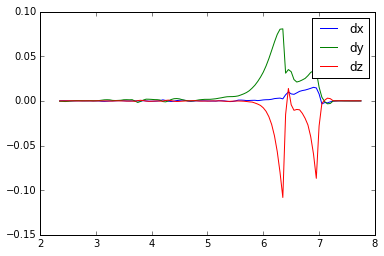

In [59]:

list_pos_x = []
list_pos_y = []
list_pos_z = []
t= []

t0 = time.time()

#poppy.r_hip_y.goto_position(-50, 4)
#poppy.r_knee_y.goto_position(50, 4)

poppy.l_shoulder_y.goto_behavior = 'minjerk'
poppy.r_shoulder_y.goto_behavior = 'minjerk'


poppy.l_shoulder_y.goto_position(80, 4)
poppy.r_shoulder_y.goto_position(80, 4)

pos = poppy.get_object_position('head_visual')
pos_x=pos[0]
pos_y=pos[1]
pos_z=pos[2]

action_passe = 0

while time.time() - t0 < 30:
    pos = poppy.get_object_position('head_visual')
    
    
    if pos_x != pos[0]:
        decalage_x=pos[0]-pos_x
        decalage_y=pos[1]-pos_y
        decalage_z=pos[2]-pos_z
    
    

        list_pos_x.append(decalage_x)
        list_pos_y.append(decalage_y)
        list_pos_z.append(decalage_z)
    
        pos_x = pos[0]
        pos_y = pos[1]
        pos_z = pos[2]
    
        t.append(poppy.current_simulation_time)
    
    time.sleep(0.05)
    
plot(t, list_pos_x)
plot(t, list_pos_y)
plot(t, list_pos_z)


legend(('dx', 'dy','dz'))


In [58]:
poppy.reset_simulation()
time.sleep(5)

On the previous graph, you can see that Poppy is falling down, because there is an unexpected movement of the head.
Now, you need to correct the movement the more quickly it is possible to ovoid the falling down and restaure the balance.
To do that we choose to make a movement in the opposite direction of the fall, using the motor abs_x and abs_y.
The problem is that we don't know what is the orientation of the motor and for example, we need to know what will be the correction of the abs_x motor.
For the motor abs_x we define a correction vector base on the orientation of the motor. The correction vector is the vector which represent in what direction the motor is able to move the gravity center of poppy. For abs_x the vector is parallele to x axis because when rotation is increasing gravity center is moving along x axis (and same sign).   
Assuming we are working with an absolute frame, we need to konw what is the coordinate of the x axis of the abs_x motor in the absolute frame. 
Get orientation return the orientation of the x axis [Vrep doc](http://www.coppeliarobotics.com/helpFiles/en/eulerAngles.htm) and using the matrix rotation you can obtain the coordinate of x axis of the motor in the reference frame [rotation matrix](http://fr.wikipedia.org/wiki/Matrice_de_rotation) 

In [17]:
# x axis of the absolute frame
Vx = mat('[1 ; 0 ; 0]')

# orientation of the motor frame
orient = poppy.get_object_orientation('abs_x')

# orthogonal matrix 3D rotation 
def rotate_matrix(orient):
    a = orient[0]
    b = orient[1]
    g = orient[2]
    Rx = array([[1,0,0], [0,cos(a),-sin(a)], [0,sin(a),cos(a)]])
    Rx = mat(Rx)
    Ry = array([[cos(b),0,sin(b)], [0,1,0], [-sin(b),0,cos(b)]])
    Ry = mat(Ry)
    Rz = array([[cos(g),-sin(g),0], [sin(g),cos(g),0], [0,0,1]])
    Rz = mat(Rz)
    Rot = Rx*Ry*Rz
    return Rot

# coordinate of motor abs_x x axis in the absolute frame
Rot = rotate_matrix(orient)
Vx_abs_x = Rot*Vx
print Vx_abs_x

# coordinate of motor  abs_y x axis in the absolute frame
orient = poppy.get_object_orientation('abs_y')
Rot = rotate_matrix(orient)
Vx_abs_y = Rot*Vx
print Vx_abs_y

[[ -9.99988896e-01]
 [ -9.97044266e-04]
 [  4.60589402e-03]]
[[  4.54054653e-04]
 [ -9.99963792e-01]
 [ -8.49750819e-03]]


Just the simpliest code to have the moving direction of the gravity center for abs_x and abs_y. You have to be careful with the sens of the move. abs_x is in direct sens (increase x when increase position) but abs_y is in the opposite direction (decrease x when increase position).

In [18]:
Vx_abs_x = rotate_matrix(poppy.get_object_orientation('abs_x'))*Vx
print Vx_abs_x

[[ -9.99990118e-01]
 [ -7.27109619e-04]
 [  4.38585109e-03]]


In [19]:
Vx_indirect = mat('[-1 ; 0 ; 0]')
Vx_abs_y = rotate_matrix(poppy.get_object_orientation('abs_y'))*Vx_indirect
print Vx_abs_y

[[ -5.04546738e-04]
 [  9.99960052e-01]
 [  8.92415977e-03]]


Now we can apply the correction in the right direction to avoid poppy falling. We have to find the good values for the motors in order to move the gravity center in the opposite direction of the fall (by resolving a equation system in the x-y plan).

In [55]:
poppy.reset_simulation()
time.sleep(5)

 
 
temps : 284.304107666
moving direction :
dx = -7.45225697756e-05
dy = 0.000515919178724
solution du système equation :
Abs_x =  [[  9.76777344e-05]]
Abs_y =  [[ 0.00051207]]
correction abs_x :  [[ 0.09767773]]
correction abs_y :  [[ 0.51206545]]
 
 
temps : 284.354095459
moving direction :
dx = -0.000111205503345
dy = 0.000342059880495
solution du système equation :
Abs_x =  [[ 0.00012658]]
Abs_y =  [[ 0.0003367]]
correction abs_x :  [[ 0.12658452]]
correction abs_y :  [[ 0.33670238]]
 
 
temps : 284.404083252
moving direction :
dx = -0.000128589570522
dy = -0.00013804063201
solution du système equation :
Abs_x =  [[ 0.00012215]]
Abs_y =  [[-0.00014374]]
correction abs_x :  [[ 0.12215036]]
correction abs_y :  [[-0.14373936]]
 
 
temps : 284.454071045
moving direction :
dx = -0.000286491587758
dy = -0.000376705080271
solution du système equation :
Abs_x =  [[ 0.00026873]]
Abs_y =  [[-0.00038952]]
correction abs_x :  [[ 0.26873154]]
correction abs_y :  [[-0.38951684]]
 
 
temps : 284

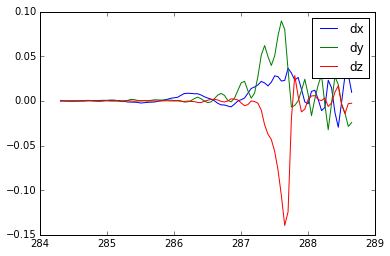

In [33]:
poppy.abs_x.goto_behavior = 'dummy'
poppy.abs_y.goto_behavior = 'dummy'

list_pos_x = []
list_pos_y = []
list_pos_z = []
t= []

t0 = time.time()

poppy.l_shoulder_y.goto_behavior = 'minjerk'
poppy.r_shoulder_y.goto_behavior = 'minjerk'


poppy.l_shoulder_y.goto_position(80, 4)
poppy.r_shoulder_y.goto_position(80, 4)


action_passex = 0
action_passey = 0

while time.time() - t0 < 30:
    
    
    
    pos = poppy.get_object_position('head_visual')
    time.sleep(0.05)
    pos2 = poppy.get_object_position('head_visual')
    
    if pos2 != pos:
        decalage_x=pos2[0]-pos[0]
        decalage_y=pos2[1]-pos[1]
        decalage_z=pos2[2]-pos[2]
        
        list_pos_x.append(decalage_x)
        list_pos_y.append(decalage_y)
        list_pos_z.append(decalage_z)
        
               
        t.append(poppy.current_simulation_time)
        print " "
        print " "
        print "temps :",poppy.current_simulation_time
        print "moving direction :"
        print "dx =",decalage_x
        print "dy =",decalage_y
    
        # x  axis of the absolute frame
        Vx = mat('[1 ; 0 ; 0]')
        

        # orientation of the motor frame
        Vx_abs_x = rotate_matrix(poppy.get_object_orientation('abs_x'))*Vx
        Vx_abs_y = rotate_matrix(poppy.get_object_orientation('abs_y'))*Vx_indirect
               
        # calculatin of the good values for position of Abs_x and Abs_y
        # resolution of the system -dx = Vx_abs_x[0]*Abs_x + Vx_abs_y[0]*Abs_y and -dy = Vx_abs_x[1]*Abs_x + Vx_abs_y[1]*Abs_y
        A3 = concatenate((Vx_abs_x,Vx_abs_y),axis=1)
        A2 = delete(A3, (2), axis=0)
        B=matrix([[decalage_x],[decalage_y]])
        solution=linalg.solve(A2,B)
        print "solution du système equation :"
        print "Abs_x = ",solution[0]
        print "Abs_y = ",solution[1]

         
        actionx =poppy.abs_x.goal_position=1000*solution[0] 
        #action_passex = actionx
        print "correction abs_x : ",actionx
        actiony =poppy.abs_y.goal_position=1000*solution[1] 
        #action_passey = actiony
        print "correction abs_y : ",actiony
        t0 = poppy.current_simulation_time
        
    
    
plot(t, list_pos_x)
plot(t, list_pos_y)
plot(t, list_pos_z)


legend(('dx', 'dy','dz'))


The system is oscillating. Now we need to find a way to avoid the oscillation.

In [84]:
poppy.reset_simulation()
time.sleep(5)

 
 
temps : 4.80000019073
moving direction :
dx = 0.000124842161313
dy = 0.000535626430064
solution du système equation :
Abs_x =  [[ 0.00012413]]
Abs_y =  [[ 0.00053584]]
correction abs_x :  [[ 0.09930596]]
correction abs_y :  [[ 0.62867535]]
 
 
temps : 4.85000038147
moving direction :
dx = 0.00018797442317
dy = 0.000312993768603
solution du système equation :
Abs_x =  [[ 0.00018761]]
Abs_y =  [[ 0.00031327]]
correction abs_x :  [[ 0.15008785]]
correction abs_y :  [[ 0.45061632]]
 
 
temps : 4.9000005722
moving direction :
dx = 0.000227992655709
dy = 4.62378375232e-05
solution du système equation :
Abs_x =  [[ 0.00022796]]
Abs_y =  [[  4.64854385e-05]]
correction abs_x :  [[ 0.18236485]]
correction abs_y :  [[ 0.23718835]]
 
 
temps : 4.95000076294
moving direction :
dx = 0.000140839954838
dy = -0.000531855039299
solution du système equation :
Abs_x =  [[ 0.00014146]]
Abs_y =  [[-0.00053167]]
correction abs_x :  [[ 0.11316425]]
correction abs_y :  [[-0.22533242]]
 
 
temps : 5.000000

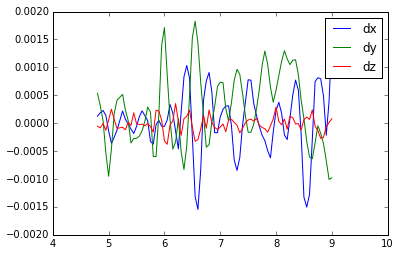

In [85]:
poppy.abs_x.goto_behavior = 'dummy'
poppy.abs_y.goto_behavior = 'dummy'

list_pos_x = []
list_pos_y = []
list_pos_z = []
t= []

t0 = time.time()

poppy.l_shoulder_y.goto_behavior = 'minjerk'
poppy.r_shoulder_y.goto_behavior = 'minjerk'


poppy.l_shoulder_y.goto_position(80, 4)
poppy.r_shoulder_y.goto_position(80, 4)


while time.time() - t0 < 30:
    
    
    
    pos = poppy.get_object_position('head_visual')
    time.sleep(0.05)
    pos2 = poppy.get_object_position('head_visual')
    
    if pos2 != pos:
        decalage_x=pos2[0]-pos[0]
        decalage_y=pos2[1]-pos[1]
        decalage_z=pos2[2]-pos[2]
        
        list_pos_x.append(decalage_x)
        list_pos_y.append(decalage_y)
        list_pos_z.append(decalage_z)
        
               
        t.append(poppy.current_simulation_time)
        print " "
        print " "
        print "temps :",poppy.current_simulation_time
        print "moving direction :"
        print "dx =",decalage_x
        print "dy =",decalage_y
    
        # x  axis of the absolute frame
        Vx = mat('[1 ; 0 ; 0]')
        

        # orientation of the motor frame
        Vx_abs_x = rotate_matrix(poppy.get_object_orientation('abs_x'))*Vx
        Vx_abs_y = rotate_matrix(poppy.get_object_orientation('abs_y'))*Vx_indirect
               
        # calculatin of the good values for position of Abs_x and Abs_y
        # resolution of the system -dx = Vx_abs_x[0]*Abs_x + Vx_abs_y[0]*Abs_y and -dy = Vx_abs_x[1]*Abs_x + Vx_abs_y[1]*Abs_y
        A3 = concatenate((Vx_abs_x,Vx_abs_y),axis=1)
        A2 = delete(A3, (2), axis=0)
        B=matrix([[-decalage_x],[decalage_y]])
        solution=linalg.solve(A2,B)
        print "solution du système equation :"
        print "Abs_x = ",solution[0]
        print "Abs_y = ",solution[1]

         
        actionx =poppy.abs_x.goal_position=poppy.abs_x.present_position + 800*solution[0] 
        
        print "correction abs_x : ",actionx
        actiony =poppy.abs_y.goal_position=poppy.abs_y.present_position + 800*solution[1] 
        
        print "correction abs_y : ",actiony
        t_wait = poppy.current_simulation_time
        #while poppy.current_simulation_time == t_wait:
        #    time.sleep(0.01)
    
    

    
plot(t, list_pos_x)
plot(t, list_pos_y)
plot(t, list_pos_z)


legend(('dx', 'dy','dz'))




Balance bahaviour is not totaly  working. On my computer Poppy fall later... V-REP behavior is sometimes very surprising (maybe because of the slowness of calcul. Some ideas to go further :
    Uses speed and acceleration of the fall to calibrate the correction.
    Wait until the correction is done, so it will be easier to calculate the balance, because the move of the motors (in partiular abs_x and abs_y) move the head so the IMU...
    Implement in primitive
    Correction with more motors and more movements
    ...